#### Imports

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import glob
import math
os.getcwd()

'D:\\series-temporales-machine-learning-main\\datos_curso_seba-main\\datos_curso_seba-main\\datos giros\\analisis2'

In [2]:
path = r"D:\HAAGCD\Trabajo-Final\datos preprocesados"
path_arch = os.path.join(path,"24h.csv")
df = pd.read_csv(path_arch, sep= ',', encoding='utf-8', dtype=np.float64).values

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_testval, y_train, y_testval = train_test_split(df[:,0:5], df[:,5], train_size=0.7, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.5, shuffle=True)

In [4]:
#los vuelvo tensores de torch
X_train = torch.FloatTensor(X_train).requires_grad_().view(-1,5)
X_test = torch.FloatTensor(X_test).requires_grad_().view(-1,5)
X_val = torch.FloatTensor(X_val).requires_grad_().view(-1,5)

y_train = torch.FloatTensor(y_train).requires_grad_().view(-1,1)
y_test = torch.FloatTensor(y_test).requires_grad_().view(-1,1)
y_val = torch.FloatTensor(y_val).requires_grad_().view(-1,1)
#X_train.shape -->torch.Size([8535, 5])


In [5]:
#RED NEURONAL
#entrada: t,x,y,To,q  salida: T

class Mired(nn.Module):
   
    def __init__(self, n_in, n_hidd, n_out):
      
        super().__init__()
        self.Lin1 = nn.Linear(n_in, n_hidd) 
        self.act =  torch.nn.Tanh()
        self.Lin2 = nn.Linear(n_hidd, n_hidd)
        self.act2 = torch.nn.Tanh()
        self.Lin3 = nn.Linear(n_hidd, n_out)
       
    def forward(self, x):
        salida = self.Lin3(self.act(self.Lin2(self.act2(self.Lin1(x)))))  
              
        return salida
 

In [6]:
input_size = X_train.shape[1]# 5
output_size = y_train.shape[1] # 1

n_hidden_size = 16

model = Mired(input_size,n_hidden_size, output_size)
crit = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = []

Epoch [10/5000], Pérdida de Entrenamiento: 28.7966, Pérdida de Validación: 28.7773
Epoch [20/5000], Pérdida de Entrenamiento: 28.4984, Pérdida de Validación: 28.4810
Epoch [30/5000], Pérdida de Entrenamiento: 28.2164, Pérdida de Validación: 28.1995
Epoch [40/5000], Pérdida de Entrenamiento: 27.9411, Pérdida de Validación: 27.9240
Epoch [50/5000], Pérdida de Entrenamiento: 27.6671, Pérdida de Validación: 27.6496
Epoch [60/5000], Pérdida de Entrenamiento: 27.3943, Pérdida de Validación: 27.3767
Epoch [70/5000], Pérdida de Entrenamiento: 27.1233, Pérdida de Validación: 27.1059
Epoch [80/5000], Pérdida de Entrenamiento: 26.8545, Pérdida de Validación: 26.8374
Epoch [90/5000], Pérdida de Entrenamiento: 26.5894, Pérdida de Validación: 26.5728
Epoch [100/5000], Pérdida de Entrenamiento: 26.3305, Pérdida de Validación: 26.3146
Epoch [110/5000], Pérdida de Entrenamiento: 26.0790, Pérdida de Validación: 26.0637
Epoch [120/5000], Pérdida de Entrenamiento: 25.8342, Pérdida de Validación: 25.8194
E

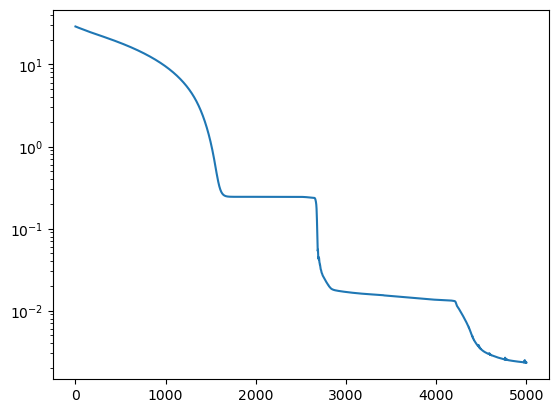

In [7]:
num_epochs = 5000
for epoch in range(num_epochs):
    # Poner el modelo en modo entrenamiento
    model.train()

    # Forward pass: calcular las predicciones
    outputs = model(X_train)

    # Calcular la pérdida
    loss = crit(outputs, y_train)

    # Backward pass: calcular gradientes
    optimizer.zero_grad() # Limpiar los gradientes anteriores
    loss.backward()       # Calcular los gradientes
    optimizer.step()      # Actualizar los pesos del modelo

    # --- 5. Bucle de Validación (cada ciertas épocas o al final de cada época) ---
    model.eval() # Poner el modelo en modo evaluación (deshabilita Dropout, etc.)
    with torch.no_grad(): # Desactivar el cálculo de gradientes para la validación (ahorra memoria y tiempo)
        val_outputs = model(X_val)
        val_loss = crit(val_outputs, y_val)
        hist.append(val_loss.item())

    if (epoch + 1) % 10 == 0: # Imprimir la pérdida cada 10 épocas
        print(f'Epoch [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {loss.item():.4f}, Pérdida de Validación: {val_loss.item():.4f}')

print("--- Entrenamiento Finalizado ---")
plt.semilogy(hist)



In [8]:
# --- 6. Evaluación en el Conjunto de Prueba ---
# Este paso se hace una ÚNICA vez al final, después de que el modelo ha sido entrenado y validado.
print("\n--- Evaluación en el Conjunto de Prueba ---")
model.eval() # Poner el modelo en modo evaluación
with torch.no_grad(): # Desactivar el cálculo de gradientes
    test_outputs = model(X_test)
    test_loss = crit(test_outputs, y_test)

    print(f'Pérdida en el conjunto de prueba: {test_loss.item():.4f}')

    # Si quisieras ver algunas predicciones vs. valores reales (solo las primeras 5):
    print("\nEjemplo de Predicciones vs. Valores Reales (primeras 5):")
    for i in range(20):
        print(f"Real: {y_test[i].item():.4f}, Predicho: {test_outputs[i].item():.4f}")


--- Evaluación en el Conjunto de Prueba ---
Pérdida en el conjunto de prueba: 0.0024

Ejemplo de Predicciones vs. Valores Reales (primeras 5):
Real: 30.2774, Predicho: 30.2333
Real: 30.2172, Predicho: 30.1262
Real: 29.9918, Predicho: 30.0791
Real: 29.9416, Predicho: 30.0046
Real: 30.1786, Predicho: 30.2075
Real: 30.4027, Predicho: 30.3560
Real: 29.1547, Predicho: 29.1724
Real: 29.4980, Predicho: 29.5920
Real: 30.0496, Predicho: 30.1654
Real: 26.5273, Predicho: 26.6990
Real: 29.9693, Predicho: 30.0695
Real: 29.9157, Predicho: 29.8861
Real: 29.8172, Predicho: 29.8633
Real: 29.9558, Predicho: 29.8753
Real: 29.9717, Predicho: 30.0397
Real: 30.3426, Predicho: 30.2957
Real: 29.7418, Predicho: 29.6989
Real: 29.4997, Predicho: 29.5532
Real: 30.0496, Predicho: 30.1628
Real: 29.8211, Predicho: 29.8685


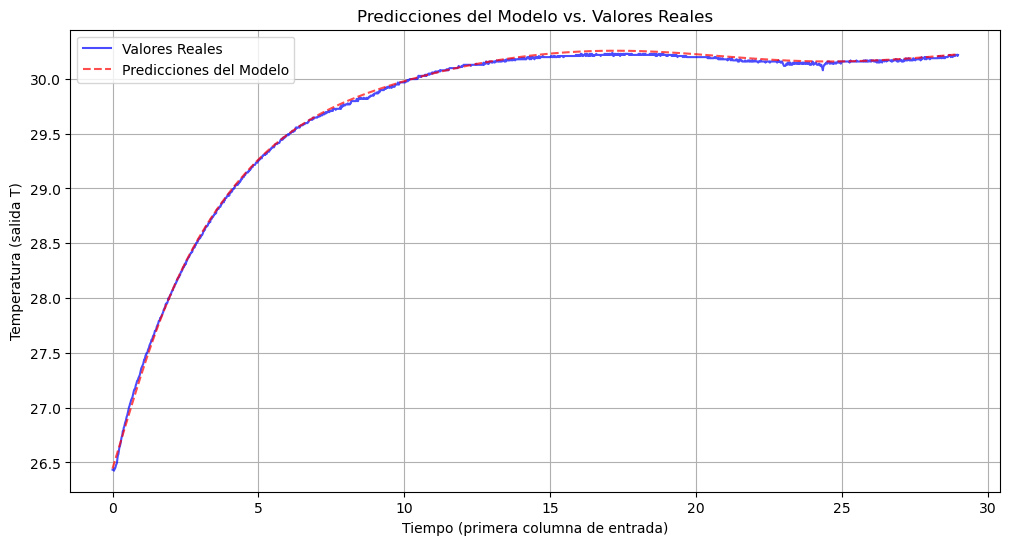

Pérdida en el conjunto de prueba: 0.0003


In [10]:
x_cheq_np = df[0:1740, 0:5] # Las características
y_cheq_np = df[0:1740, 5]

# Convertir a tensores de PyTorch (¡sin .requires_grad_()!)
x_cheq_tensor = torch.tensor(x_cheq_np, dtype=torch.float32)
y_cheq_tensor = torch.tensor(y_cheq_np, dtype=torch.float32).unsqueeze(1) # Añadir dimensión para que sea (N, 1)

# La primera columna de x_cheq_np es el "tiempo" (asumido para el eje X)
time_values = x_cheq_np[:, 0]

#Obtener las predicciones del modelo para estos datos
model.eval() # Poner el modelo en modo evaluación
with torch.no_grad(): # Desactivar el cálculo de gradientes
    predictions_tensor = model(x_cheq_tensor)
    cheq_loss = crit(predictions_tensor, y_cheq_tensor)

# Convertir las predicciones de tensor de PyTorch a array de NumPy para graficar
predictions_np = predictions_tensor.squeeze(1).numpy() # .squeeze(1) para quitar la dimensión extra si es (N, 1) y convertir a (N,)

# 3. Crear la gráfica
plt.figure(figsize=(12, 6)) # Tamaño de la figura para mejor visualización

# Graficar los valores reales
plt.plot(time_values, y_cheq_np, label='Valores Reales', color='blue', alpha=0.7)

# Graficar las predicciones
plt.plot(time_values, predictions_np, label='Predicciones del Modelo', color='red', linestyle='--', alpha=0.7)

plt.title('Predicciones del Modelo vs. Valores Reales')
plt.xlabel('Tiempo (primera columna de entrada)')
plt.ylabel('Temperatura (salida T)')
plt.legend() # Muestra la leyenda de las etiquetas
plt.grid(True) # Añade una cuadrícula al gráfico
plt.show() # Muestra la ventana de la gráfica
print(f'Pérdida en el conjunto de prueba: {cheq_loss.item():.4f}')


--- Realizando Ajuste de Curva Exponencial ---
Parámetros del ajuste exponencial: 
  y0 = 30.2057
  A1 = -3.7880
  t1 = 3.5922

Pérdida del Ajuste Exponencial (MSE): 0.0013
Pérdida del Ajuste Exponencial (MAE): 0.0307
Pérdida del Ajuste Exponencial (crit): 0.0007
Pérdida en el conjunto de prueba con modelo: 0.0003


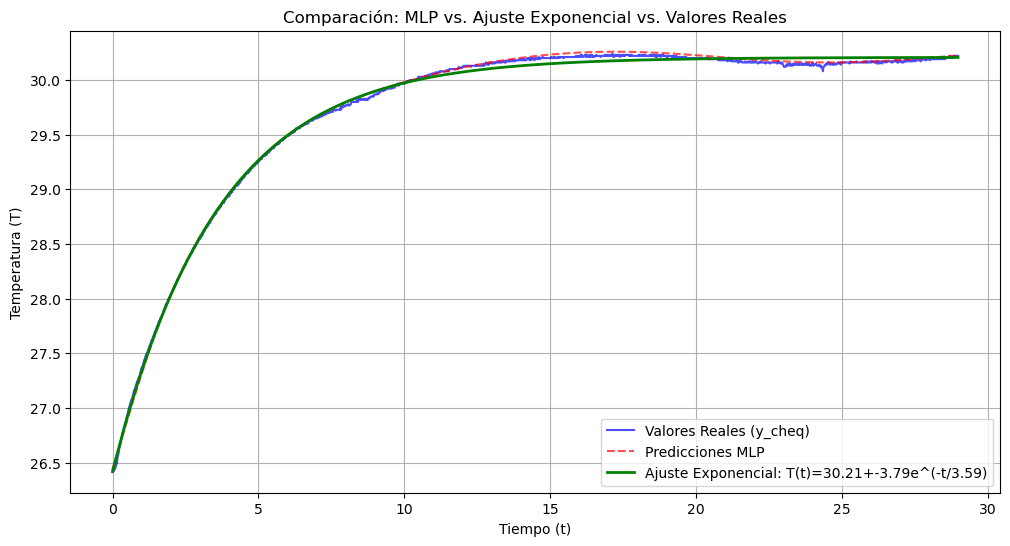

In [20]:
from scipy.optimize import curve_fit
# --- 1. Preparar los datos para el ajuste ---
# Ya tienes x_cheq_np[:, 0] como 't' y y_cheq_np como 'T'
# Asegúrate de que y_cheq_np sea un array 1D para el ajuste si no lo es ya
t_data = x_cheq_np[:, 0]
T_data = y_cheq_np # y_cheq_np ya debe ser (N,) si no aplicaste .unsqueeze(1) al extraerlo.
                   # Si y_cheq_np vino de y_cheq_tensor.squeeze(1).numpy(), entonces ya es 1D.

print("\n--- Realizando Ajuste de Curva Exponencial ---")

# 2. Definir la función exponencial para el ajuste
def exponential_decay(t, y0, A1, t1):
    """
    Función de decaimiento exponencial: T(t) = y0 + A1 * exp(-t/t1)
    """
    return y0 + A1 * np.exp(-t / t1)

# 3. Realizar el ajuste de la curva
# Los valores iniciales (p0) son importantes para que el algoritmo de ajuste converja.
# Puedes ajustar estos valores según la naturaleza de tus datos.
# y0: valor asintótico (la T cuando t es muy grande)
# A1: amplitud inicial
# t1: constante de tiempo de decaimiento
initial_guess = [T_data.min(), T_data.max() - T_data.min(), np.mean(t_data) / 2]

try:
    # curve_fit devuelve los parámetros óptimos y la matriz de covarianza
    popt, pcov = curve_fit(exponential_decay, t_data, T_data, p0=initial_guess)
    y0_opt, A1_opt, t1_opt = popt

    print(f"Parámetros del ajuste exponencial: ")
    print(f"  y0 = {y0_opt:.4f}")
    print(f"  A1 = {A1_opt:.4f}")
    print(f"  t1 = {t1_opt:.4f}")

    # 4. Calcular los valores predichos por el modelo ajustado
    T_adjusted = exponential_decay(t_data, y0_opt, A1_opt, t1_opt)
    
    T_adjusted_tensor = torch.tensor(T_adjusted, dtype=torch.float32).unsqueeze(1)
    T_data_tensor = torch.tensor(T_data, dtype=torch.float32).unsqueeze(1) 
    # 5. Calcular el "loss" (error) entre el ajuste y los datos reales
    # Puedes usar el Error Cuadrático Medio (MSE) o el Error Absoluto Medio (MAE)
    loss_adjustment_mse = np.mean((T_data - T_adjusted)**2)
    loss_adjustment_mae = np.mean(np.abs(T_data - T_adjusted))
    loss_ajuste = crit(T_data_tensor,T_adjusted_tensor)

    print(f"\nPérdida del Ajuste Exponencial (MSE): {loss_adjustment_mse:.4f}")
    print(f"Pérdida del Ajuste Exponencial (MAE): {loss_adjustment_mae:.4f}")
    print(f"Pérdida del Ajuste Exponencial (crit): {loss_ajuste:.4f}")
    print(f'Pérdida en el conjunto de prueba con modelo: {cheq_loss.item():.4f}')
    
    

    # 6. Graficar el ajuste junto con los datos reales y las predicciones de la NN
    plt.figure(figsize=(12, 6))
    plt.plot(t_data, T_data, label='Valores Reales (y_cheq)', color='blue', alpha=0.7)
    plt.plot(t_data, predictions_np, label='Predicciones MLP', color='red', linestyle='--', alpha=0.7) # Las predicciones de tu red neuronal
    plt.plot(t_data, T_adjusted, label=f'Ajuste Exponencial: T(t)={y0_opt:.2f}+{A1_opt:.2f}e^(-t/{t1_opt:.2f})', color='green', linestyle='-', linewidth=2)

    plt.title('Comparación: MLP vs. Ajuste Exponencial vs. Valores Reales')
    plt.xlabel('Tiempo (t)')
    plt.ylabel('Temperatura (T)')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"Error al realizar el ajuste de curva: {e}")
    print("Intenta ajustar los valores iniciales (p0) o verificar la calidad de tus datos.")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el ajuste: {e}")